In [1]:
import librosa
from librosa import feature
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import os
import sys
import time

In [4]:
def extract_features(file):

    # check if normal or abnormal
    if 'abnormal' in file:
        operation=1
    else:
        operation=0
    # loading the file, getting y and sr (sample rate)

    y, sr = librosa.load(file)

    # Getting S and phase

    S, phase = librosa.magphase(librosa.stft(y=y))

    # Features for the DataFrame
# chroma features have pitch which is probably not usefull
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))

    chroma_cqt = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr))

    chroma_cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr))
# to do
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
    melspectrogram_min = np.min(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
    melspectrogram_max = np.max(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
    melspectrogram_sum = librosa.feature.melspectrogram(y=y, sr=sr, S=S).sum()
    melspectrogram_corr= np.mean(np.corrcoef(librosa.feature.melspectrogram(y=y, sr=sr, S=S)))
    melspectrogram_std= np.std(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
# to check This feature is one of the most important method to extract a feature of an audio signal and is 
#used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal 
#are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral 
#envelope.
    
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr))
#rms when plotted similarities with melspectorgram
#normal rms mean higher than abnormal?
    rms = np.mean(librosa.feature.rms(y=y, S=S))
#spectral centroid computes weighted mean of the frequencies in the sound
#plot is line on melspectogram
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, S=S))
#Bandwidth(blue zone) is the difference between the upper and lower frequencies in a continuous band of frequencies
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr, S=S))
#needs further investigation, but makes continous data discrete in bins
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, S=S))
#Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to
#being tone-like 1. A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. 
#It is often converted to decibel.
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y, S=S))
#The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at 
#least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and 
#he bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent 
#to a value close to 1 (or 0).
#rolloff with rolloff coefficient 0.01 seems to be the same for (ab)normal
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, S=S))
#Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram
    poly_features = np.mean(librosa.feature.poly_features(y=y, sr=sr, S=S))
#probably chroma
    tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr))
#normal has higher zero crossing rate?
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
#divide in frequency bands could give more information bout difference normal and abnormal (BPM)
    #tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                       #    hop_length=hop_length)[0]
    # putting them into a dataframe
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    return pd.DataFrame({ 'melspectrogram' : [melspectrogram],'melspectrogram_min':[melspectrogram_min],
                             'melspectrogram_max':[melspectrogram_max], 'melspectrogram_sum':[melspectrogram_sum],
                             'melspectrogram_corr':[melspectrogram_corr] ,'melspectrogram_std':[melspectrogram_std] ,
                             'mfcc' : [mfcc], 'rms' : [rms],
                            'spectral_centroid' : [spectral_centroid], 'spectral_bandwidth' : [spectral_bandwidth],
                            'spectral_contrast' : [spectral_contrast], 'spectral_flatness ' : [spectral_flatness],
                            'spectral_rolloff' : [spectral_rolloff], 
                            'zero_crossing_rate' : [zero_crossing_rate],"mean harm": np.mean(y_harmonic),
                            "mean perc": [np.mean(y_percussive)],"max harm":[np.max(y_harmonic)],"max perc": [np.max(y_percussive)],
                             "min harm":[np.min(y_harmonic)], "min perc":[np.min(y_percussive)], 'normal(0)/abnormal(1)':[operation]})

In [9]:
def create_df(machine,dB_value):
    # start measuring excecution time
    start_time = time.time()
    #create empty list that will be filled with pathnames
    #find paths normal wav files
    list_normal_6 = []
    num=[0,2,4,6]
    for i in num:
        directory_normal_6 = f"/home/regis/Desktop/Sound Project/files/{machine}/{dB_value}_dB_{machine}/{machine}/id_0{i}/normal/"
        for filename in os.listdir(directory_normal_6):
            file = f"{directory_normal_6}{filename}"
            list_normal_6.append(file)
    list_normal_6.sort()
    #find paths abnormal wav files
    list_abnormal_6 = []
    num=[0,2,4,6]
    for i in num:
        directory_abnormal_6 = f"/home/regis/Desktop/Sound Project/files/{machine}/{dB_value}_dB_{machine}/{machine}/id_0{i}/abnormal/"
        for filename in os.listdir(directory_abnormal_6):
            file = f"{directory_abnormal_6}{filename}"
            list_abnormal_6.append(file)
    list_abnormal_6.sort()
    #add normal to df
    for wav_file in list_normal_6:
        df = extract_features(wav_file)
        if wav_file == list_normal_6[0]:
            df.to_csv(f'Librosa_features_{machine}_{dB_value}dB.csv')
        else:
            df.to_csv(f'Librosa_features_{machine}_{dB_value}dB.csv', mode='a', header=False)
    #add abnormal to df
    for wav_file in list_abnormal_6:
        df = extract_features(wav_file)
        df.to_csv(f'Librosa_features_{machine}_{dB_value}dB.csv', mode='a', header=False) 
    print("--- %s seconds ---" % (time.time() - start_time))

In [25]:
create_df('fan',6)

KeyboardInterrupt: 

In [11]:
fan=pd.read_csv('/home/regis/Desktop/machines/Codit-project/Librosa_features_fan_6dB.csv')

In [13]:
fan.head()

,Unnamed: 0,melspectrogram,melspectrogram_min,melspectrogram_max,melspectrogram_sum,melspectrogram_corr,melspectrogram_std,mfcc,rms,spectral_centroid,...,spectral_flatness,spectral_rolloff,zero_crossing_rate,mean harm,mean perc,max harm,max perc,min harm,min perc,normal(0)/abnormal(1)
0,0,0.008870,1.207413e-09,0.217286,489.342621,0.036707,0.015815,-12.846735,0.004381,1178.821555,...,0.000259,2419.762476,0.045237,-5.000726e-07,3.347033e-07,0.013364,0.005517,-0.017440,-0.009582,0
1,0,0.008814,1.201971e-09,0.185242,486.255402,0.031088,0.015326,-12.400963,0.004300,1121.206650,...,0.000249,2226.338355,0.043883,5.480459e-07,-7.577547e-07,0.012119,0.006364,-0.013770,-0.009580,0
2,0,0.009081,1.190875e-09,0.243309,500.994965,0.056441,0.016951,-11.675858,0.004623,1075.123813,...,0.000209,2288.689718,0.037140,-2.303674e-07,-3.882094e-07,0.012165,0.007161,-0.014607,-0.008991,0
3,0,0.008999,1.170776e-09,0.184777,496.479675,0.031641,0.015704,-12.594336,0.004298,1208.611399,...,0.000302,2681.633204,0.046175,-1.519910e-06,-7.811252e-07,0.014037,0.007088,-0.013732,-0.008618,0
4,0,0.008867,1.094482e-09,0.211936,489.166473,0.071156,0.016454,-11.836786,0.004419,1009.561703,...,0.000181,2114.075925,0.035681,1.178300e-06,1.809838e-06,0.011839,0.007703,-0.012396,-0.008645,0


In [14]:
fan.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [15]:
fan.dtypes

melspectrogram           float64
melspectrogram_min       float64
melspectrogram_max       float64
melspectrogram_sum       float64
melspectrogram_corr      float64
melspectrogram_std       float64
mfcc                     float64
rms                      float64
spectral_centroid        float64
spectral_bandwidth       float64
spectral_contrast        float64
spectral_flatness        float64
spectral_rolloff         float64
zero_crossing_rate       float64
mean harm                float64
mean perc                float64
max harm                 float64
max perc                 float64
min harm                 float64
min perc                 float64
normal(0)/abnormal(1)      int64
dtype: object

In [17]:
y=fan['normal(0)/abnormal(1)'].values
x=fan.drop(columns=['normal(0)/abnormal(1)'], axis=1)

In [18]:
#Choosing 80% as training data.
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [19]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0)
classifier.fit(xTrain, yTrain)
y_pred = classifier.predict(xTest)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('confusion matrix')
print(confusion_matrix(yTest, y_pred))
print('classification report')
print(classification_report(yTest, y_pred))
print('accuracy score')
print(accuracy_score(yTest, y_pred))

confusion matrix
[[810   2]
 [  8 290]]
classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       812
           1       0.99      0.97      0.98       298

    accuracy                           0.99      1110
   macro avg       0.99      0.99      0.99      1110
weighted avg       0.99      0.99      0.99      1110

accuracy score
0.990990990990991


In [22]:
x_columns=list(x.columns)

Feature: 0,	 Name: melspectrogram, 	 Score: 13.06419
Feature: 1,	 Name: melspectrogram_min, 	 Score: 0.00000
Feature: 2,	 Name: melspectrogram_max, 	 Score: 6.17300
Feature: 3,	 Name: melspectrogram_sum, 	 Score: 13.38387
Feature: 4,	 Name: melspectrogram_corr, 	 Score: 1.37803
Feature: 5,	 Name: melspectrogram_std, 	 Score: 13.78466
Feature: 6,	 Name: mfcc, 	 Score: 7.42677
Feature: 7,	 Name: rms, 	 Score: 9.83120
Feature: 8,	 Name: spectral_centroid, 	 Score: 3.68234
Feature: 9,	 Name: spectral_bandwidth, 	 Score: 2.44295
Feature: 10,	 Name: spectral_contrast, 	 Score: 1.32891
Feature: 11,	 Name: spectral_flatness , 	 Score: 4.01964
Feature: 12,	 Name: spectral_rolloff, 	 Score: 4.15536
Feature: 13,	 Name: zero_crossing_rate, 	 Score: 5.35715
Feature: 14,	 Name: mean harm, 	 Score: 0.44324
Feature: 15,	 Name: mean perc, 	 Score: 0.26326
Feature: 16,	 Name: max harm, 	 Score: 4.17245
Feature: 17,	 Name: max perc, 	 Score: 0.97088
Feature: 18,	 Name: min harm, 	 Score: 6.13777
Feature:

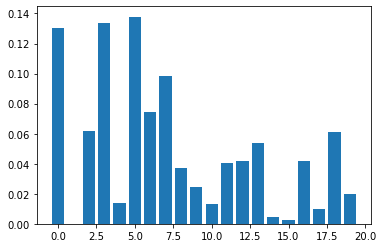

In [23]:
# get importance
importance = classifier.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: %0d,\t Name: {x_columns[i]}, \t Score: %.5f' % (i,v*100))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [24]:
6230/60

103.83333333333333